  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

100%|██████████| 170498071/170498071 [00:02<00:00, 77283439.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


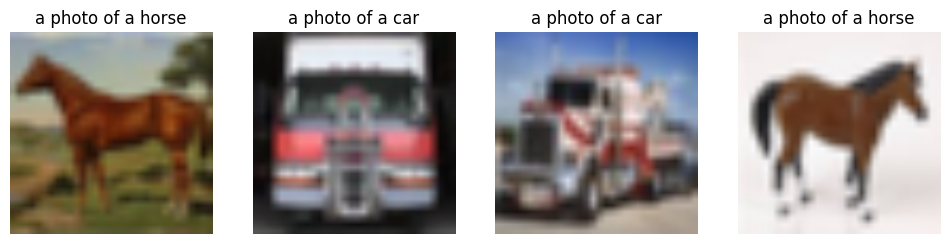

In [1]:
# Step 1: Install necessary packages
!pip install torch torchvision transformers pillow

# Step 2: Import Libraries
import torch
from transformers import CLIPProcessor, CLIPModel
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pretrained CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Step 3: Load and preprocess the dataset (using CIFAR-10 for this example)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Get a few samples from the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# Step 4: Define text prompts for zero-shot classification
text_prompts = ["a photo of a cat", "a photo of a dog", "a photo of a horse", "a photo of a car", "a photo of a plane"]

# Tokenize text prompts
inputs = processor(text=text_prompts, return_tensors="pt", padding=True)

# Perform zero-shot classification
model.eval()
with torch.no_grad():
    for images, _ in dataloader:
        # Preprocess images
        images = images * 0.5 + 0.5  # Unnormalize images for visualization

        # Encode images and text
        image_features = model.get_image_features(pixel_values=images)
        text_features = model.get_text_features(**inputs)

        # Compute similarity scores
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = image_features @ text_features.T

        # Get the labels with the highest similarity scores
        labels = similarity.argmax(dim=-1).cpu().numpy()

        # Display the images and their predicted labels
        fig, axs = plt.subplots(1, 4, figsize=(12, 3))
        for i, ax in enumerate(axs):
            ax.imshow(transforms.ToPILImage()(images[i]))
            ax.set_title(text_prompts[labels[i]])
            ax.axis('off')
        plt.show()

        break  # Only process one batch for this example
